# Helper functions

In [1]:
import pandas as pd
import json

d4j_perturbed_bugs = { "Chart-26", "Cli-1" , "Closure-106" , "Codec-1" , 
                  "Collections-25" , "Compress-1" , "Csv-1" , "Gson-1" ,
                  "JacksonCore-1" , "JacksonDatabind-1" , "JacksonXml-1" ,
                  "Jsoup-1" , "JxPath-1" , "Lang-65" , "Math-106" ,
                  "Mockito-28" , "Time-27"
                 }

bears_perturbed_bugs = {"Bears-140","Bears-1","Bears-194","Bears-196","Bears-213",
                        "Bears-205","Bears-232","Bears-204","Bears-98","Bears-251",
                        "Bears-153","Bears-180","Bears-165","Bears-207","Bears-198",
                        "Bears-186","Bears-210","Bears-190","Bears-241","Bears-166",
                        "Bears-199","Bears-200","Bears-234","Bears-240","Bears-250",
                        "Bears-223","Bears-144","Bears-212","Bears-214","Bears-169",
                        "Bears-242","Bears-246","Bears-156","Bears-84","Bears-238",
                        "Bears-157","Bears-202","Bears-231","Bears-243","Bears-247",
                        "Bears-233","Bears-239","Bears-220","Bears-245","Bears-158",
                        "Bears-209","Bears-188","Bears-229","Bears-193","Bears-230",
                        "Bears-211","Bears-221","Bears-222","Bears-228","Bears-248",
                        "Bears-201","Bears-224","Bears-176","Bears-27","Bears-227",
                        "Bears-249","Bears-142","Bears-225","Bears-159","Bears-170",
                        "Bears-197","Bears-226","Bears-184","Bears-177","Bears-149",
                        "Bears-206","Bears-155"}

def read_eval_d4j(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(d4j_perturbed_bugs)]
    return df

def read_eval_bears(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(bears_perturbed_bugs)]
    return df

In [2]:
def get_number_compile(df, k):
    count = 0
    all_count = 0
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            all_count += 1
            if fix["compile_exec"] and fix["compile_pass"]:
                count += 1
    return "%d / %d (%.2f%%)" % (count, all_count, count/all_count*100)

In [3]:
def get_number_test(df, k):
    count = 0
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            if (fix["test_exec"] and fix["test_pass"]) or fix["identical"]:
                count += 1
                break
    return "%d / %d (%.2f%%)" % (count, len(df), count/len(df)*100)

In [4]:
def get_bugs_test(df, k=100):
    count = 0
    bugs = set()
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            if (fix["test_exec"] and fix["test_pass"]) or fix["identical"]:
                bugs.add(index)
                break
    return bugs

In [5]:
ex_label = { "defects4j_buglab" : "Defects4J x Buglab",
            "defects4j_selfapr" : "Defects4J x SelfAPR",
            "bears_buglab" : "Bears x Buglab",
            "bears_selfapr" : "Bears x SelfAPR",
           }
round_label = { "round0" : "Initialization",
               "round1-nocritic" : "Initialization + BIFI4J(keepall)",
               "round1-compiler" : "Initialization + BIFI4J(compiler)",
               "round1-tests" : "Initialization + BIFI4J(tests)",
              }


def get_model_label(ex, ro):
    return ex_label[ex] + ": " + round_label[ro]

# Results Table

In [6]:
def get_table_entry(model_label, rounds, cb, tb, tbc, cd, td, tdc):
    return {"Model": {
                "" :   { "" : model_label }
            },
            "Testing":{
                "Bears Compile" : dict(zip(rounds, cb)),
                "Bears Plausible" : dict(zip(rounds, tb)),
                "Bears Correct" : dict(zip(rounds, tbc)),
                "Defects4J Compile" : dict(zip(rounds, cd)),
                "Defects4J Plausible" : dict(zip(rounds, td)),
                "Defects4J Correct" : dict(zip(rounds, tdc))
            }
       }

In [7]:
from os.path import exists

entries = []
#top_k = [1, 5, 10, 25, 50, 100]
top_k = [100]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)
        bears_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % (ex, ro_path)
        d4j_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % (ex, ro_path)
        
        cb = [get_number_compile(read_eval_bears(bears_path_plausible), k) for k in top_k] if exists(bears_path_plausible) else ["N/A" for _ in top_k]
        tb = [get_number_test(read_eval_bears(bears_path_plausible), k) for k in top_k] if exists(bears_path_plausible) else ["N/A" for _ in top_k]
        tbc = [get_number_test(read_eval_bears(bears_path_correct), k) for k in top_k] if exists(bears_path_correct) else ["N/A" for _ in top_k]
        cd = [get_number_compile(read_eval_d4j(d4j_path_plausible), k) for k in top_k] if exists(d4j_path_plausible) else ["N/A" for _ in top_k]
        td = [get_number_test(read_eval_d4j(d4j_path_plausible), k) for k in top_k] if exists(d4j_path_plausible) else ["N/A" for _ in top_k]
        tdc = [get_number_test(read_eval_d4j(d4j_path_correct), k) for k in top_k] if exists(d4j_path_correct) else ["N/A" for _ in top_k]
        
        entries += [get_table_entry(get_model_label(ex, ro) , top_k, cb, tb, tbc, cd, td, tdc)]

In [8]:
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
table = pd.json_normalize(data=entries)
table.columns = table.columns.str.split(".").map(tuple)
table

Model              Testing  \
                                                             Bears Compile   
                                                                       100   
0                  Defects4J x Buglab: Initialization   187 / 3700 (5.05%)   
1   Defects4J x Buglab: Initialization + BIFI4J(ke...                  N/A   
2   Defects4J x Buglab: Initialization + BIFI4J(co...                  N/A   
3   Defects4J x Buglab: Initialization + BIFI4J(te...                  N/A   
4                 Defects4J x SelfAPR: Initialization    68 / 3700 (1.84%)   
5   Defects4J x SelfAPR: Initialization + BIFI4J(k...   102 / 3700 (2.76%)   
6   Defects4J x SelfAPR: Initialization + BIFI4J(c...   189 / 3700 (5.11%)   
7   Defects4J x SelfAPR: Initialization + BIFI4J(t...   154 / 3700 (4.16%)   
8                      Bears x Buglab: Initialization  632 / 3700 (17.08%)   
9    Bears x Buglab: Initialization + BIFI4J(keepall)                  N/A   
10  Bears x Buglab: Initialization + BIFI4J(compiler)                  N/A   
11     Bears x Buglab: Initialization + BIFI4J(tests)                  N/A   
12                    Bears x SelfAPR: Initialization  886 / 3700 (23.95%)   
13  Bears x SelfAPR: Initialization + BIFI4J(keepall)                  N/A   
14  Bears x SelfAPR: Initialization + BIFI4J(compi...                  N/A   
15    Bears x SelfAPR: Initialization + BIFI4J(tests)                  N/A   

                                                            \
    Bears Plausible   Bears Correct      Defects4J Compile   
                100             100                    100   
0    3 / 37 (8.11%)  0 / 37 (0.00%)  7071 / 47900 (14.76%)   
1               N/A             N/A                    N/A   
2               N/A             N/A                    N/A   
3               N/A             N/A                    N/A   
4   4 / 37 (10.81%)  0 / 37 (0.00%)                    N/A   
5   5 / 37 (13.51%)  0 / 37 (0.00%)                    N/A   
6   5 / 37 (13.51%)  0 / 37 (0.00%)                    N/A   
7   5 / 37 (13.51%)  0 / 37 (0.00%)                    N/A   
8    2 / 37 (5.41%)  0 / 37 (0.00%)                    N/A   
9               N/A             N/A                    N/A   
10              N/A             N/A                    N/A   
11              N/A             N/A                    N/A   
12  7 / 37 (18.92%)  1 / 37 (2.70%)  6215 / 47900 (12.97%)   
13              N/A             N/A  8108 / 47900 (16.93%)   
14              N/A             N/A                    N/A   
15              N/A             N/A                    N/A   

                                          
   Defects4J Plausible Defects4J Correct  
                   100               100  
0     23 / 479 (4.80%)  12 / 479 (2.51%)  
1                  N/A               N/A  
2                  N/A               N/A  
3                  N/A               N/A  
4                  N/A               N/A  
5                  N/A               N/A  
6                  N/A               N/A  
7                  N/A               N/A  
8                  N/A               N/A  
9                  N/A               N/A  
10                 N/A               N/A  
11                 N/A               N/A  
12   54 / 479 (11.27%)  24 / 479 (5.01%)  
13   66 / 479 (13.78%)               N/A  
14                 N/A               N/A  
15                 N/A               N/A

# RQ1: To what extent does the perturbation model choice impact the model's repair accuracy?

In [12]:
def get_rq1table_entry(model_label, tb, td):
    return {"Model": {
                "" : model_label
            },
            "Test Dataset":{
                "Bears" : tb,
                "Defects4J v2.0" : td
            }
       }

In [13]:
from os.path import exists

entries = []
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)
        bears_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % (ex, ro_path)
        d4j_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % (ex, ro_path)
        
        tb = get_number_test(read_eval_bears(bears_path_plausible), 100).split("/")[0].strip() if exists(bears_path_plausible) else "?"
        tbc = get_number_test(read_eval_bears(bears_path_correct), 100).split("/")[0].strip() if exists(bears_path_correct) else "?"
        td = get_number_test(read_eval_d4j(d4j_path_plausible), 100).split("/")[0].strip() if exists(d4j_path_plausible) else "?"
        tdc = get_number_test(read_eval_d4j(d4j_path_correct), 100).split("/")[0].strip() if exists(d4j_path_correct) else "?"
        
        entries += [get_rq1table_entry(get_model_label(ex, ro), tbc + "/" + tb, tdc + "/" + td)]
        
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
table = pd.json_normalize(data=entries)
table.columns = table.columns.str.split(".").map(tuple)

print(table.to_latex(caption="Effectiveness of the fixer models over the Bears and Defects4J test datasets.", 
                  label="tab:rq1_repair_accuracy",
                  index=False,
                  multicolumn_format="c",
                  position="htbp")
     )

table

\begin{table}[htbp]
\centering
\caption{Effectiveness of the fixer models over the Bears and Defects4J test datasets.}
\label{tab:rq1_repair_accuracy}
\begin{tabular}{lll}
\toprule
                              Model & \multicolumn{2}{c}{Test Dataset} \\
                                    &        Bears & Defects4J v2 \\
\midrule
 Defects4J x Buglab: Initialization &          0/3 &        12/23 \\
Defects4J x SelfAPR: Initialization &          0/4 &          ?/? \\
     Bears x Buglab: Initialization &          0/2 &          ?/? \\
    Bears x SelfAPR: Initialization &          1/7 &        24/54 \\
\bottomrule
\end{tabular}
\end{table}



Model Test Dataset             
                                              Bears Defects4J v2
0   Defects4J x Buglab: Initialization          0/3        12/23
1  Defects4J x SelfAPR: Initialization          0/4          ?/?
2       Bears x Buglab: Initialization          0/2          ?/?
3      Bears x SelfAPR: Initialization          1/7        24/54

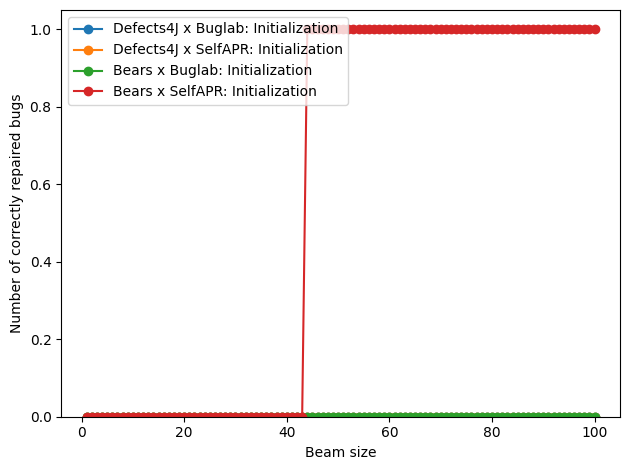

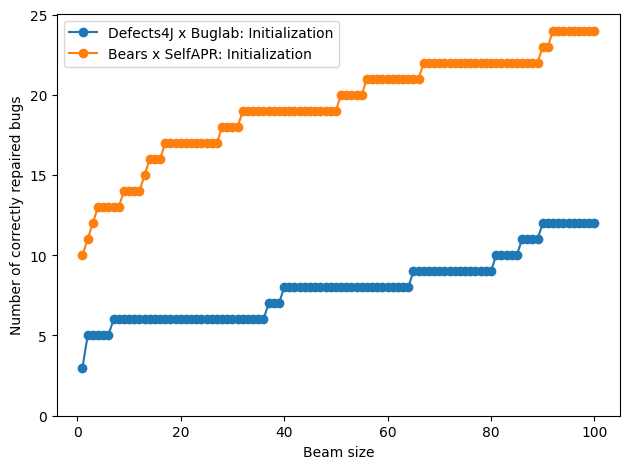

In [37]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
#top_k = [1, 5, 10, 25, 50, 100]
top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]

plt.figure("defects4j")
plt.figure("bears")

for ex in experiments:
    bears_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % ex
    d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % ex

    if exists(bears_path):
        tb = [int(get_number_test(read_eval_bears(bears_path), k).split("/")[0]) for k in top_k]
        plt.figure("bears")
        plt.plot(top_k, tb, "-o", label=get_model_label(ex, "round0"))
        
    if exists(d4j_path):
        td = [int(get_number_test(read_eval_d4j(d4j_path), k).split("/")[0]) for k in top_k] 
        plt.figure("defects4j")
        plt.plot(top_k, td, "-o", label=get_model_label(ex, "round0"))

plt.figure("bears")
plt.legend(loc="upper left")
plt.xlabel("Beam size")
plt.ylabel("Number of correctly repaired bugs")
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig("./results/rq1/repair_accuracy_bears.svg")

plt.figure("defects4j")
plt.legend(loc="upper left")
plt.xlabel("Beam size")
plt.ylabel("Number of correctly repaired bugs")
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig("./results/rq1/repair_accuracy_d4j.svg")

plt.show()

Experiment: defects4j_buglab


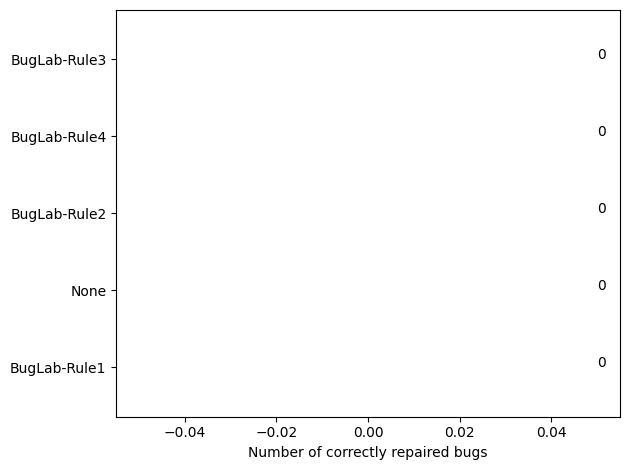

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/JacksonCore-5/src/main/java/com/fasterxml/jackson/core/JsonPointer.java	2022-10-14 19:25:56.849632052 +0200
+++ /tmp/tmp57wq49of.java	2022-10-14 19:25:56.849632052 +0200
@@ -188,11 +188,11 @@
         // have arrays over 2 billion entries so ints are fine.
         if (len == 0 || len > 10) {
             return -1;
         }
         for (int i = 0; i < len; ++i) {
-            char c = str.charAt(i++);
+char c = str.charAt(i);
             if (c > '9' || c < '0') {
                 return -1;
             }
         }
         if (len == 10) {

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/Cli-17/src/java/org/apache/commons/cli/PosixParser.java	2022-10-15 03:59:47.415127943 +0200
+++ /tmp/tmpc1d9901f.java	2022-10-15 03:59:47.419127923 +0200
@@ -298,10 +298,11 @@
                 }
             }
             else if (stopAtNonOption)
             {
                 process(token.substring

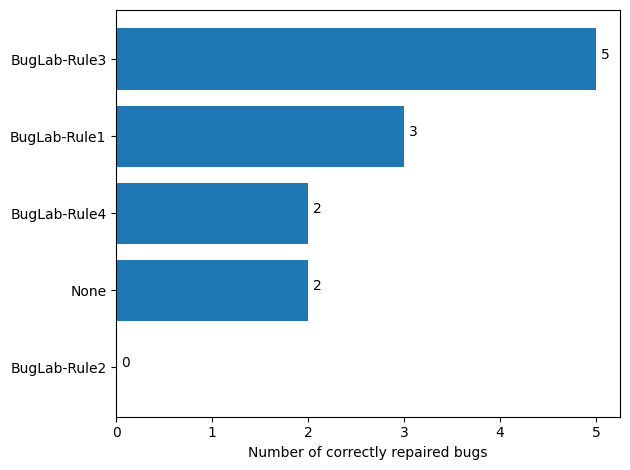


----------------------------------------------------------------------------------------------------

Experiment: defects4j_selfapr


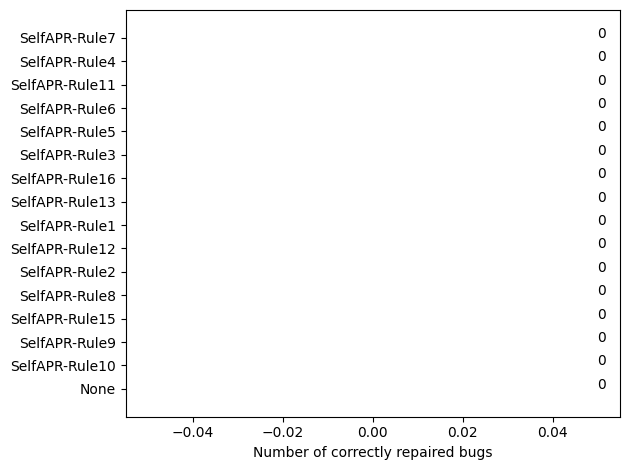


----------------------------------------------------------------------------------------------------

Experiment: bears_buglab


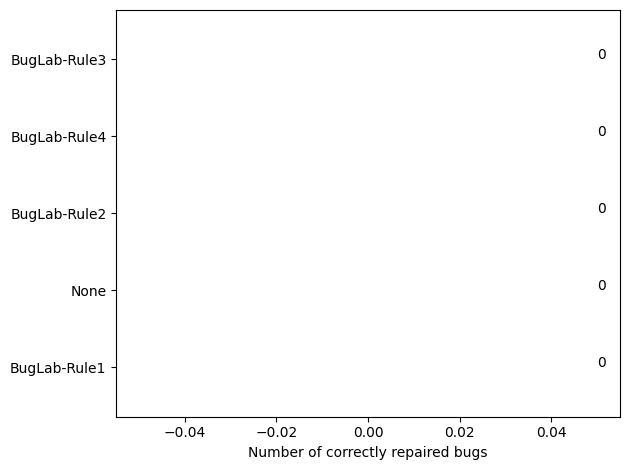


----------------------------------------------------------------------------------------------------

Experiment: bears_selfapr


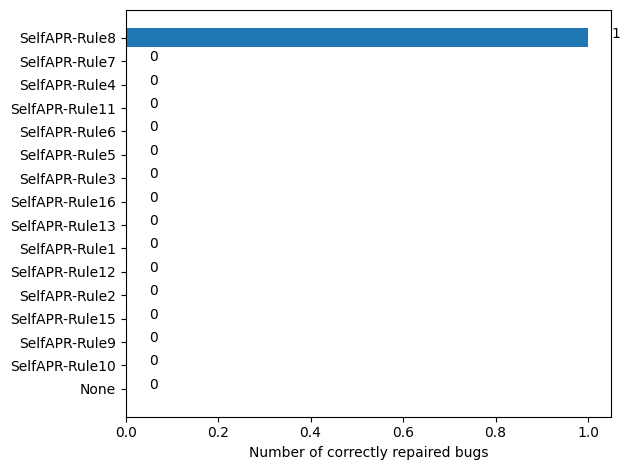

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/JacksonDatabind-12/src/main/java/com/fasterxml/jackson/databind/deser/std/MapDeserializer.java	2022-10-05 19:00:07.424385312 +0200
+++ /tmp/tmpf0lqth5i.java	2022-10-05 19:00:07.428385290 +0200
@@ -298,11 +298,11 @@
     @Override
     public boolean isCachable() {
         /* As per [databind#735], existence of value or key deserializer (only passed
          * if annotated to use non-standard one) should also prevent caching.
          */
-        return (_valueTypeDeserializer == null)
+if (_valueTypeDeserializer == null) return false; return (_valueTypeDeserializer == null)
                 && (_ignorableProperties == null);
     }
 
     @Override
     @SuppressWarnings("unchecked")

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/Collections-26/src/main/java/org/apache/commons/collections4/keyvalue/MultiKey.java	2022-10-05 19:54:04.928742496 +0200
+++ /tmp/tmpsewbpku6.java	2022-10-05 19:5

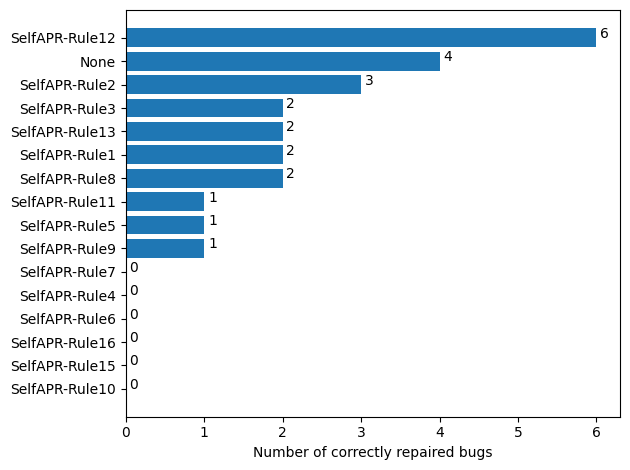


----------------------------------------------------------------------------------------------------



In [38]:
from os.path import exists
from matplotlib import pyplot as plt


experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]

buglab_rules = {
        "BugLab-Rule1",
        "BugLab-Rule2",
        "BugLab-Rule3",
        "BugLab-Rule4",
        "None"
        }

selfapr_rules = {
        "SelfAPR-Rule1",
        "SelfAPR-Rule2",
        "SelfAPR-Rule3",
        "SelfAPR-Rule4",
        "SelfAPR-Rule5",
        "SelfAPR-Rule6",
        "SelfAPR-Rule7",
        "SelfAPR-Rule8",
        "SelfAPR-Rule9",
        "SelfAPR-Rule10",
        "SelfAPR-Rule11",
        "SelfAPR-Rule12",
        "SelfAPR-Rule13",
        "SelfAPR-Rule13",
        "SelfAPR-Rule15",
        "SelfAPR-Rule16",
        "None"
        }

for ex in experiments:
    bears_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % ex
    d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % ex
    rules = buglab_rules if "buglab" in ex else selfapr_rules
    
    print("Experiment: " + ex)
    
    if exists(bears_path):
        rule_frequency = dict.fromkeys(rules, 0)
        df = read_eval_bears(bears_path)
        
        for index, row in df.iterrows():
            for fix in row[0]:
                if fix["validation"]:
                    rule_frequency[fix["rule"].split(":")[0]] += 1
                    if "None" in fix["rule"]:
                        print(fix["patch"])
                    break
        
        rule_frequency = dict(sorted(rule_frequency.items(), key=lambda item: item[1]))
        plt.barh(list(rule_frequency.keys()), list(rule_frequency.values()))
        for index, value in enumerate(list(rule_frequency.values())):
            plt.text(value + 0.05, index, str(value))
        plt.xlabel("Number of correctly repaired bugs")
        plt.tight_layout()
        plt.savefig("results/rq1/%s_%s_rule_freq.svg" % (ex, "bears"))
        plt.show()       

    if exists(d4j_path):
        rule_frequency = dict.fromkeys(rules, 0)
        df = read_eval_d4j(d4j_path)
        
        for index, row in df.iterrows():
            for fix in row[0]:
                if fix["validation"]:
                    rule_frequency[fix["rule"].split(":")[0]] += 1
                    if "None" in fix["rule"]:
                        print(fix["patch"])                    
                    break
        
        rule_frequency = dict(sorted(rule_frequency.items(), key=lambda item: item[1]))
        for index, value in enumerate(list(rule_frequency.values())):
            plt.text(value + 0.05, index, str(value))
        plt.barh(list(rule_frequency.keys()), list(rule_frequency.values()))
        plt.xlabel("Number of correctly repaired bugs")
        plt.tight_layout()
        plt.savefig("results/rq1/%s_%s_rule_freq.svg" % (ex, "defects4j"))
        plt.show()
        
    print()
    print("-" * 100)
    print()

# RQ2: To what extent does the BIFI setup, and the critic choice, impact the repair accuracy?

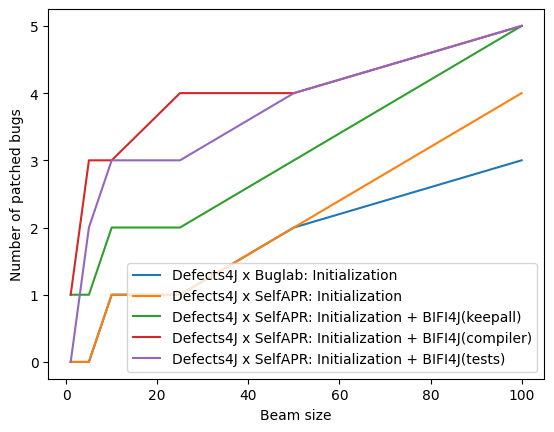

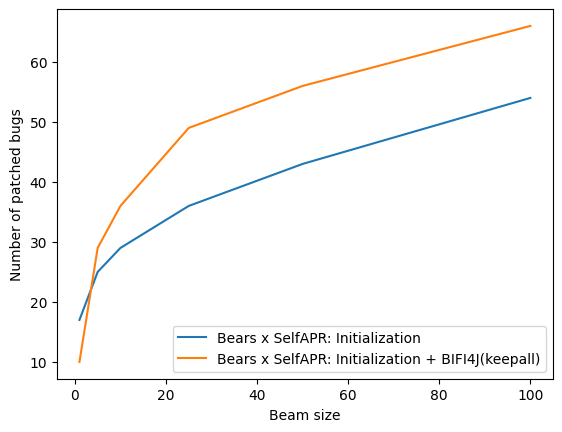

In [16]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [1, 5, 10, 25, 50, 100]
#top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

plt.figure("defects4j")
plt.figure("bears")

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)

        if "defects4j" in ex:
            if exists(bears_path):
                tb = [int(get_number_test(read_eval_bears(bears_path), k).split("/")[0]) for k in top_k]
                plt.figure("bears")
                plt.plot(top_k, tb, label=get_model_label(ex, ro))

        if "bears" in ex:
            if exists(d4j_path):
                td = [int(get_number_test(read_eval_d4j(d4j_path), k).split("/")[0]) for k in top_k] 
                plt.figure("defects4j")
                plt.plot(top_k, td, label=get_model_label(ex, ro))

plt.figure("bears")
plt.legend()
plt.xlabel("Beam size")
plt.ylabel("Number of patched bugs")

plt.figure("defects4j")
plt.legend()
plt.xlabel("Beam size")
plt.ylabel("Number of patched bugs")
                
plt.legend()
plt.show()

### What bugs can round1-X fix that round0 cannot?

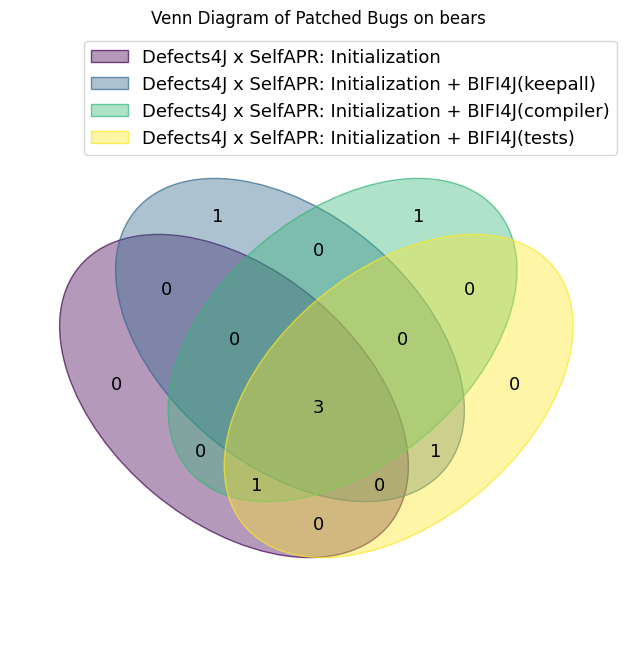

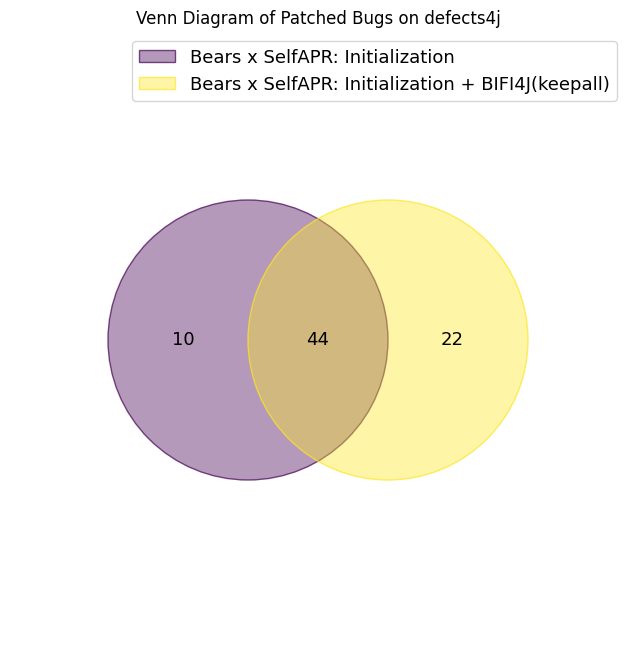

In [17]:
from os.path import exists
from venn import venn
import matplotlib.pyplot as plt
%matplotlib inline

experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
bifi_rounds = ["round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    eval_dataset = "defects4j" if "bears" in ex else "bears"
    read_eval = read_eval_d4j if "defects4j" in eval_dataset else read_eval_bears
    
    path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_%s_bw_100.json" % (ex, eval_dataset)
    if not exists(path): continue
    patches = {get_model_label(ex, "round0") : get_bugs_test(read_eval(path))}
    
    for ro in bifi_rounds:
        path = "/mnt/data/andre/mscthesis/experiments/%s/%s/part2/fixer/eval_single_hunk_%s_bw_100.json" % (ex, ro, eval_dataset)
        if not exists(path): continue
        patches[get_model_label(ex, ro)] = get_bugs_test(read_eval(path))

    if len(patches) >= 2:
        venn(patches)
        plt.title("Venn Diagram of Patched Bugs on %s" % eval_dataset)
        plt.show()

# RQ3: To what extent does the BIFI setup, and the critic choice, impact the compilability of generated patches?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


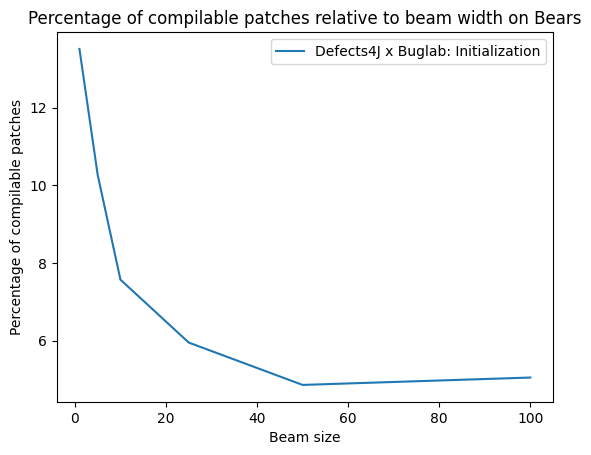

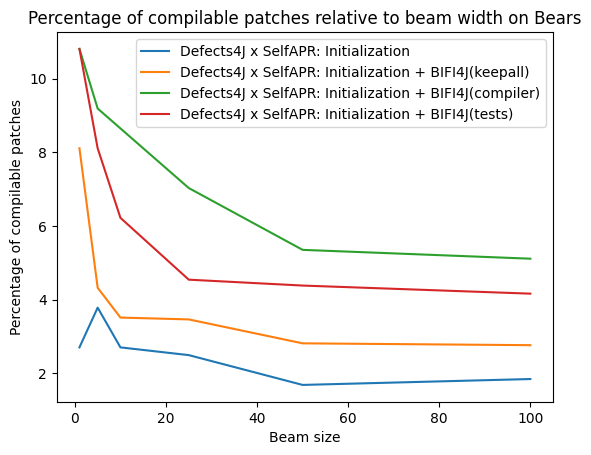

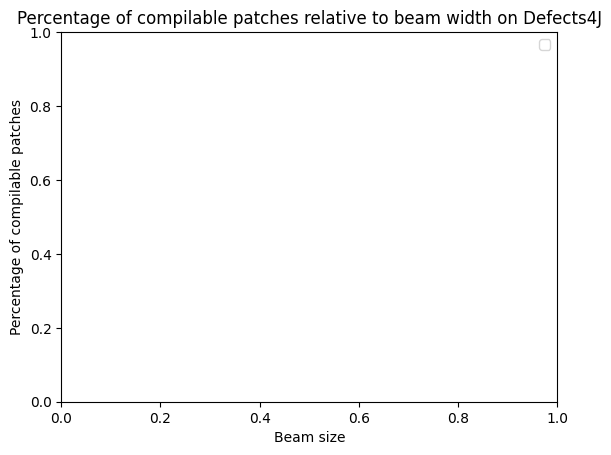

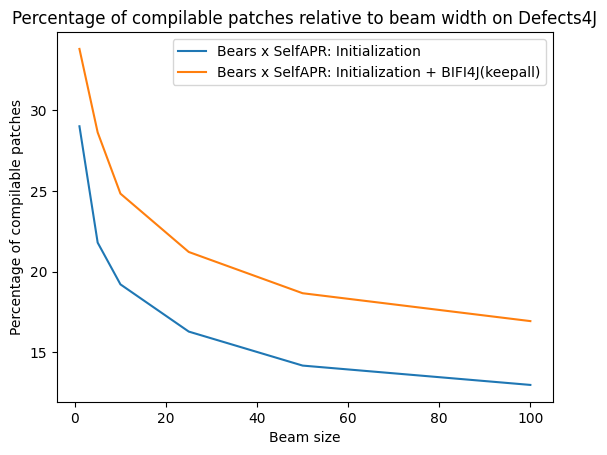

In [18]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [1, 5, 10, 25, 50, 100]
#top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

plt.figure("defects4j_buglab")
plt.figure("defects4j_selfapr")
plt.figure("bears_buglab")
plt.figure("bears_selfapr")

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)

        if "defects4j" in ex:
            if exists(bears_path):
                cb = [float(get_number_compile(read_eval_bears(bears_path), k).split("(")[1].split("%")[0]) for k in top_k]
                plt.figure(ex)
                plt.plot(top_k, cb, label=get_model_label(ex, ro))

        if "bears" in ex:
            if exists(d4j_path):
                cd = [float(get_number_compile(read_eval_d4j(d4j_path), k).split("(")[1].split("%")[0]) for k in top_k]
                plt.figure(ex)
                plt.plot(top_k, cd, label=get_model_label(ex, ro))

for ex in experiments:
    plt.figure(ex)
    plt.legend()
    plt.title("Percentage of compilable patches relative to beam width on %s" % ("Defects4J" if "bears" in ex else "Bears"))
    plt.xlabel("Beam size")
    plt.ylabel("Percentage of compilable patches")
                
plt.legend()
plt.show()